## Base.ipynb

In [1]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError

In [2]:
# Read dataframe from memory
PICKLE_PATH = "Pickles"
df = pd.read_pickle(os.path.join(PICKLE_PATH, "df.pkl"))

In [3]:
# Utility for displaying images
def imshow(img, size, title, path=True):
    if path == True:
        img = cv2.imread(img, 0)
    plt.figure(figsize=size)
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

In [4]:
# img1 = cv2.imread(df['Grayscale'][1], 0)
# img1 = (img1 - np.min(img1)) / (np.max(img1) - np.min(img1))
# img2 = cv2.imread(df['Grayscale'][2], 0)
# img2 = (img2 - np.min(img2)) / (np.max(img2) - np.min(img2))
# diff = img2 - img1
# cnt = 0
# for i in range(width):
#     for j in range(height):
#         if diff[i][j] > 100:
#             cnt += 1
# print(cnt)
# plt.imshow(diff, cmap='gray')
# plt.show()

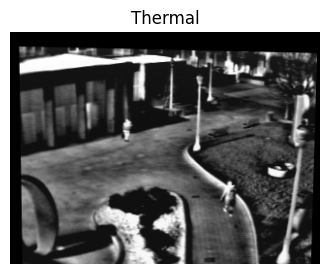

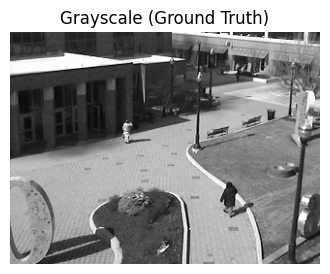

In [4]:
# Display a thermal and correspoding grayscale image
imshow(df['Thermal'][0], (4, 4), "Thermal")
imshow(df['Grayscale'][0], (4, 4), "Grayscale (Ground Truth)")

In [5]:
# Store the dimensions of image
sample = cv2.imread(df['Thermal'][0], 0)
width, height = sample.shape
tot_pixels = height * width

In [6]:
perc_images = 0.02 # Hyperparameter for choosing % images
perc_pixels = 1    # Hyperparameter for choosing % pixels
window_size = 7    # Hyperparameter for choosing side of square window
df_sample = df.sample(frac=perc_images, random_state=42) 

In [7]:
# Utlity function to check for validity of a pixel
def is_valid(x, y):
    return x >= 0 and x < width and y >= 0 and y < height

In [8]:
# Utility function to get context window pixels
def get_dirs(n):
    n = (n + 1) // 2
    dirs = []
    for i in range(n):
        for j in range(n):
            for k in [(1, 1), (1, -1), (-1, 1), (-1, -1)]:
                x, y = i * k[0], j * k[1]
                if ((x, y) not in dirs):
                    dirs.append((x, y))
    dirs.remove((0, 0))
    return dirs

In [9]:
# Dictionary to store pixel, target and context information
pixel_data = {'Pixel': [], 'Target': []}
for i in range(1, 25):
    pixel_data[f'Context_{i}'] = []

flag, prev = False, None
dirs = get_dirs(window_size)
for idx in range(len(df_sample)):
    # Selecting a random sample of pixels
    pix_i = np.random.choice(width, int(perc_pixels * width), replace=False)
    pix_j = np.random.choice(height, int(perc_pixels * height), replace=False)
    thermal = cv2.imread(df_sample['Thermal'].iloc[idx], 0)
    gray = cv2.imread(df_sample['Grayscale'].iloc[idx], 0)
    # Image normalization
    thermal = (thermal - np.min(thermal)) / (np.max(thermal) - np.min(thermal))
    gray = (gray - np.min(gray)) / (np.max(gray) - np.min(gray))
    # Check with previous thermal
    if flag == True:
        diff = thermal - prev
    prev = thermal
    
    gen = ((i, j) for i in pix_i for j in pix_j)
    for i, j in gen:
        # Append center pixel
        if flag == True and diff[i][j] > 0:
            pixel_data['Pixel'].append(thermal[i][j])
            pixel_data['Target'].append(gray[i][j])
            # Append context window pixels
            for cnt, direction in enumerate(dirs):
                x, y, key = i + direction[0], j + direction[1], f'Context_{cnt + 1}'
                if is_valid(x, y):
                    pixel_data[key].append(thermal[x][y])
                else:
                    pixel_data[key].append(0)
    flag = True

df_new = pd.DataFrame(pixel_data)
df_new.head()

,Pixel,Target,Context_1,Context_2,Context_3,Context_4,Context_5,Context_6,Context_7,Context_8,...,Context_15,Context_16,Context_17,Context_18,Context_19,Context_20,Context_21,Context_22,Context_23,Context_24
0,0.494118,0.260870,0.486275,0.494118,0.470588,0.494118,0.486275,0.478431,0.482353,0.494118,...,0.478431,0.454902,0.478431,0.486275,0.454902,0.447059,0.478431,0.490196,0.454902,0.431373
1,0.454902,0.438735,0.454902,0.458824,0.458824,0.462745,0.458824,0.466667,0.454902,0.470588,...,0.470588,0.466667,0.470588,0.470588,0.466667,0.458824,0.466667,0.474510,0.462745,0.450980
2,0.274510,0.916996,0.141176,0.403922,0.074510,0.501961,0.274510,0.262745,0.145098,0.403922,...,0.278431,0.247059,0.141176,0.415686,0.117647,0.384314,0.078431,0.501961,0.078431,0.501961
3,0.490196,0.197628,0.490196,0.494118,0.490196,0.498039,0.490196,0.447059,0.490196,0.490196,...,0.466667,0.321569,0.474510,0.454902,0.341176,0.301961,0.482353,0.443137,0.364706,0.282353
4,0.588235,0.252964,0.552941,0.580392,0.521569,0.556863,0.556863,0.600000,0.509804,0.564706,...,0.529412,0.627451,0.490196,0.529412,0.635294,0.600000,0.486275,0.505882,0.647059,0.560784


In [9]:
# df_new.to_pickle('Pickles/df_new_3.pkl')
df_new = pd.read_pickle('Pickles/df_new_7*7.pkl')
df_new.shape
# We have ~6.5 million samples

(2834895, 50)

In [10]:
# Data split - 70% training, 20% validation, 10% testing
y = df_new['Target']
X = df_new.drop(['Target'], axis=1)
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.33, random_state=42)

In [11]:
# Create neural network model
model = Sequential()
model.add(Dense(64,  kernel_initializer='normal', activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(128, kernel_initializer='normal', activation='relu'))
model.add(Dense(256, kernel_initializer='normal', activation='relu'))
# model.add(Dense(256, kernel_initializer='normal', activation='relu'))
model.add(Dense(1,   kernel_initializer='normal', activation='linear'))
model.compile(optimizer='Adam', loss='mean_squared_error')
model.load_weights('Weights/Best-7x7-151-0.02323.hdf5')

In [12]:
WEIGHTS_DIR = "Weights"
if not os.path.isdir(WEIGHTS_DIR):
    os.mkdir(WEIGHTS_DIR)
model.load_weights("Weights/Best-130-0.02478.hdf5")

In [ ]:
# Train the model
EPOCHS = 1000
BATCH_SIZE = 32
checkpoint_name = os.path.join(WEIGHTS_DIR, "Best-Cont-{epoch:03d}-{val_loss:.5f}.hdf5")
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
callbacks = [early_stopping]
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val),
                    epochs=EPOCHS, batch_size=BATCH_SIZE, 
                    callbacks=callbacks)

In [14]:
# Evaluate the model on testing data
model.evaluate(X_test, y_test)

8771/8771 [==============================] - 4s 438us/step - loss: 0.0231


0.023124443367123604

In [12]:
# Reconstruct a test image
img_test = df_sample.iloc[0]
img_recon = np.zeros((width, height))
dirs = get_dirs(window_size)
thermal = cv2.imread(img_test['Thermal'], 0)
gray = cv2.imread(img_test['Grayscale'], 0)
thermal = (thermal - np.min(thermal)) / (np.max(thermal) - np.min(thermal))
gray = (gray - np.min(gray)) / (np.max(gray) - np.min(gray))
for i in range(width):
    for j in range(height):
        pixels = [[thermal[i][j]]]
        for direction in dirs:
            x, y = i + direction[0], j + direction[1]
            if is_valid(x, y):
                pixels[0].append(thermal[x][y])
            else:
                pixels[0].append(0)
        img_recon[i][j] = model.predict(pixels)[0][0]

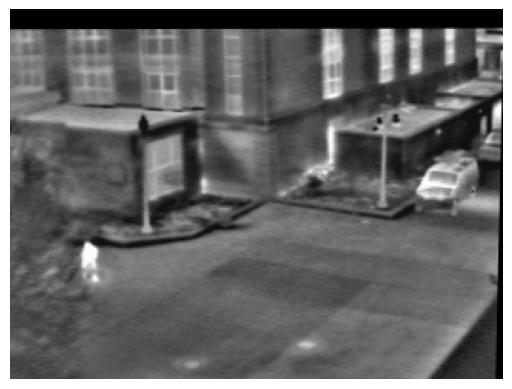

In [13]:
plt.imshow(thermal, cmap='gray')
plt.axis('off')
plt.savefig('Thermal.png')
plt.show()

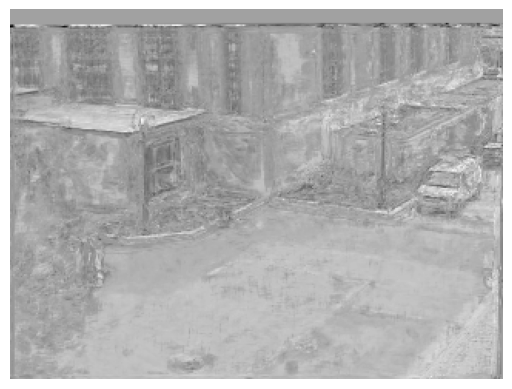

In [14]:
plt.imshow(img_recon, cmap='gray')
plt.axis('off')
plt.savefig('Recon.png')
plt.show()

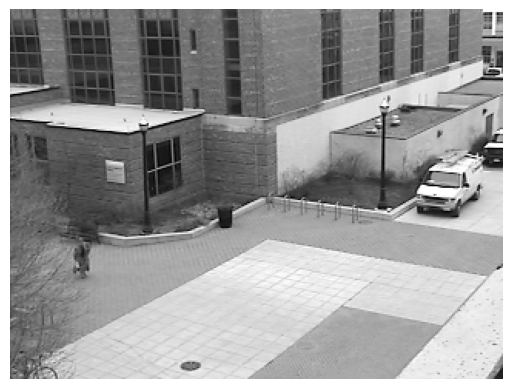

In [15]:
plt.imshow(gray, cmap='gray')
plt.axis('off')
plt.savefig('Grayscale.png')
plt.show()

In [71]:
# Postprocessing
recon = cv2.imread("Recon.png", 0)
thermal = cv2.imread("Thermal.png", 0)
gray = cv2.imread("Grayscale.png", 0)
blur = cv2.GaussianBlur(recon, (5, 5), 0)
kernel = np.array([[-1, -1, -1], 
                   [-1,  8, -1],
                   [-1, -1, -1]])
kernel = kernel / (np.sum(kernel) if np.sum(kernel) != 0 else 1)
high_pass = cv2.filter2D(thermal, -1, kernel)
img_final = blur - high_pass

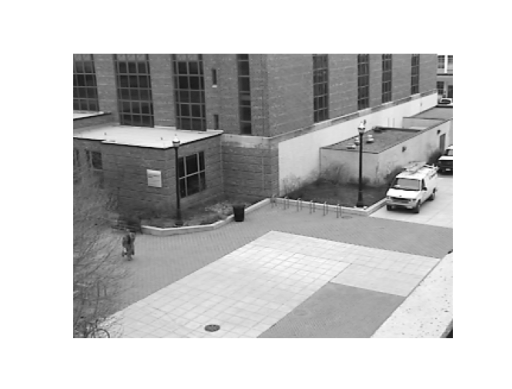

In [57]:
plt.imshow(gray, cmap='gray')
plt.axis('off')
plt.show()

In [72]:
gray = (gray - np.min(gray)) / (np.max(gray) - np.min(gray))
img_final = (img_final - np.min(img_final)) / (np.max(img_final) - np.min(img_final))
recon = (recon - np.min(recon)) / (np.max(recon) - np.min(recon))
mse = 0
for i in range(len(gray)):
    for j in range(len(gray[0])):
        mse += (gray[i][j] - recon[i][j]) ** 2
mse = mse / (gray.shape[0] * gray.shape[1])
rmse = np.sqrt(mse)
print(mse, rmse)

0.022752773576055957 0.1508402253248647


In [73]:
mse = 0
for i in range(len(gray)):
    for j in range(len(gray[0])):
        mse += (gray[i][j] - img_final[i][j]) ** 2
mse = mse / (gray.shape[0] * gray.shape[1])
rmse = np.sqrt(mse)
print(mse, rmse)

0.022706013011803385 0.1506851452924388


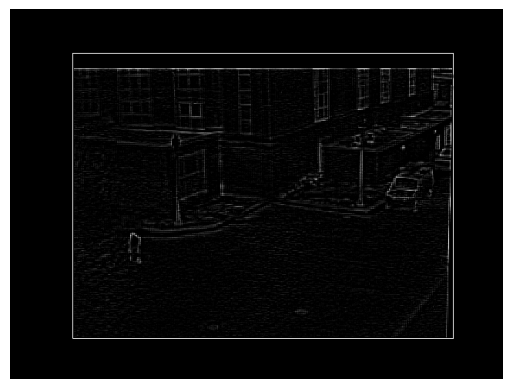

In [60]:
plt.imshow(high_pass, cmap='gray')
plt.axis('off')
plt.show()

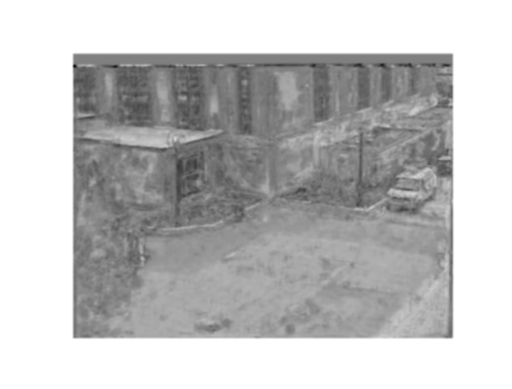

In [61]:
plt.imshow(blur, cmap='gray')
plt.axis('off')
plt.show()

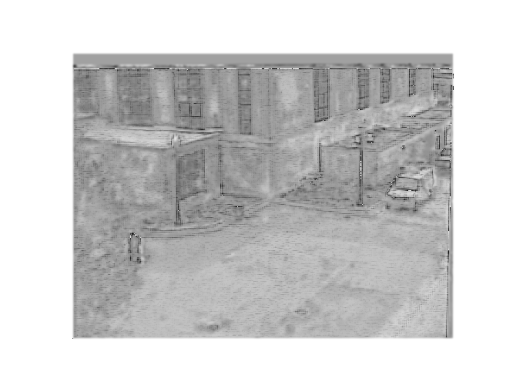

In [69]:
plt.imshow(img_final, cmap='gray')
plt.axis('off')
plt.show()